In [20]:
import pandas as pd
from itertools import islice
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
sns.set(style='darkgrid')

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1]:
# reading in Client with Probe type as Client1
source1 = 'data/820Metrotech_test.txt'

clients1 = []
with open(source1, 'r') as f:
    for i, client in enumerate(f):
        if 'Client' in client:
            client = client.replace(':',';',1)
            for j in range(i, i+8):
                n = f.next()
                if 'First' in n:
                    F = n
                if 'Last' in n:
                    L = n
                if 'Type' in n:
                    T = n
                    
                j+= 1
               
            clients1.append(client+';'+F+';'+L +';' + T)
            #print n

In [2]:
len(clients1)

1261

In [3]:
# check multi client records
client2 = []
with open(source1, 'r') as f:
    num1 = 0
    num2 = 0
    num3 = 0
    num4 = 0
    num5 = 0
    num6 = 0
    num7 = 0
    num8 = 0
    num9 = 0
    num10 = 0
    for i, client in enumerate(f):
        if 'Client 1' in client:
            num1 += 1
        if 'Client 2' in client:
            num2 += 1
        if 'Client 3' in client:
            num3 += 1
        if 'Client 4' in client:
            num4 += 1
        if 'Client 5' in client:
            num5 += 1
        if 'Client 6' in client:
            num6 += 1
        if 'Client 7' in client:
            num7 += 1
        if 'Client 8' in client:
            num8 += 1
        if 'Client 9' in client:
            num9 += 1
        if 'Client 10' in client:
            num10 += 1


In [4]:
multi_rec = [num1, num2, num3, num4, num5, num6, num7, num8, num9, num10]

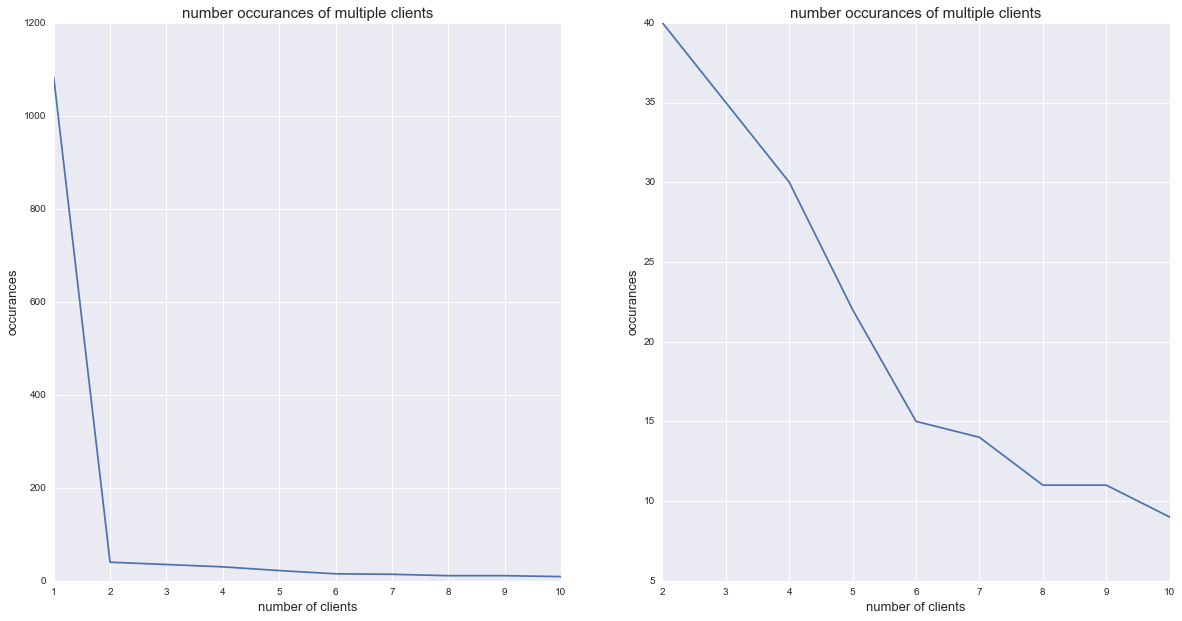

In [7]:
# plot multi clients
plt.figure(figsize = [20,10])
plt.subplot(121)
plt.plot(range(1,11), multi_rec)
plt.title('number occurances of multiple clients', fontsize = 15)
plt.xlabel('number of clients', fontsize = 13)
plt.ylabel('occurances', fontsize = 13)

plt.subplot(122)
plt.plot(range(2,11), multi_rec[1:])
plt.title('number occurances of multiple clients', fontsize = 15)
plt.xlabel('number of clients', fontsize = 13)
plt.ylabel('occurances', fontsize = 13)

plt.savefig('./visuals/num_occur_multi_clients_2.png')

In [8]:
df = pd.DataFrame(columns=['client', 'MAC','first','last', 'type'])

## Add Clients to dataframe
for client in clients1:
    df = df.append(pd.Series(client.split(';'), index=['client','MAC','first','last', 'type']), ignore_index=True)

## Clean up MACA Address column
df.MAC = df.MAC.str.replace('MAC ' , '')
df.MAC = df.MAC.str.replace(r'\n','')
df['first'] = df['first'].str.replace(' First      : ' , '')
df['first'] = df['first'].str.replace(r'\n','')
df['last'] = df['last'].str.replace(' Last       : ' , '')
df['last'] = df['last'].str.replace(r'\n','')

In [11]:
df.head()

,client,MAC,first,last,type
0,Client 1,00:00:00:00:00:00,Tue Apr 18 18:28:36 2017,Tue Apr 18 19:48:04 2017,Type : Ad-hoc\n
1,Client 1,B0:70:2D:7E:C5:53,Tue Apr 18 18:42:15 2017,Tue Apr 18 18:42:45 2017,Type : To Distribution\n
2,Client 1,00:03:7F:00:00:00,Tue Apr 18 18:31:50 2017,Tue Apr 18 18:31:50 2017,Type : Ad-hoc\n
3,Client 1,00:04:20:F3:E1:10,Tue Apr 18 19:22:24 2017,Tue Apr 18 19:22:24 2017,Type : Probe Request\n
4,Client 1,00:04:4B:2F:66:A2,Tue Apr 18 18:31:24 2017,Tue Apr 18 19:46:17 2017,Type : Probe Request\n


In [13]:
def time(row):
    
    week, month, day, time, year = row[3].split(' ')[1:]
    week1, month1, day1, time1, year1 = row[2].split(' ')[1:]
    time = datetime.datetime.strptime(time, '%H:%M:%S')
    time1 = datetime.datetime.strptime(time1, '%H:%M:%S')
    
    return time-time1

df['time_diff'] = df.apply(time, axis = 1)                            

### A single MAC address covers multiple clients - If we assume a MAC suggests a router:

In [18]:
print 'from this experiment, we successfully detected {} devices from {} routers'.format(len(df), len(df.MAC.value_counts()))

from this experiment, we successfully detected 1261 devices from 1162 routers


### Some devices were detected to have very short time period - it could still mean they were physically around the location

In [19]:
print 'number of devices detected with very short time period:'
print df[df['first'] != df['last']].shape[0]

number of devices detected with very short time period:
752


### However, devices with very long time period can be: 
- staying around the area for other matters
## Thus, consider removing records with long time difference

In [26]:
print 'maximum time difference detected is:', df.time_diff.max()

maximum time difference detected is: 0 days 01:19:59


In [25]:
df_long = df[df.time_diff > pd.tslib.Timedelta('0 days 01:19:00')]
print '{} detcected records have time difference longer than 1 hour 19 minutes'.format(len(df_long))

73 detcected records have time difference longer than 1 hour 19 minutes


In [27]:
df_test = df[df.time_diff <= pd.tslib.Timedelta('0 days 01:19:00')]

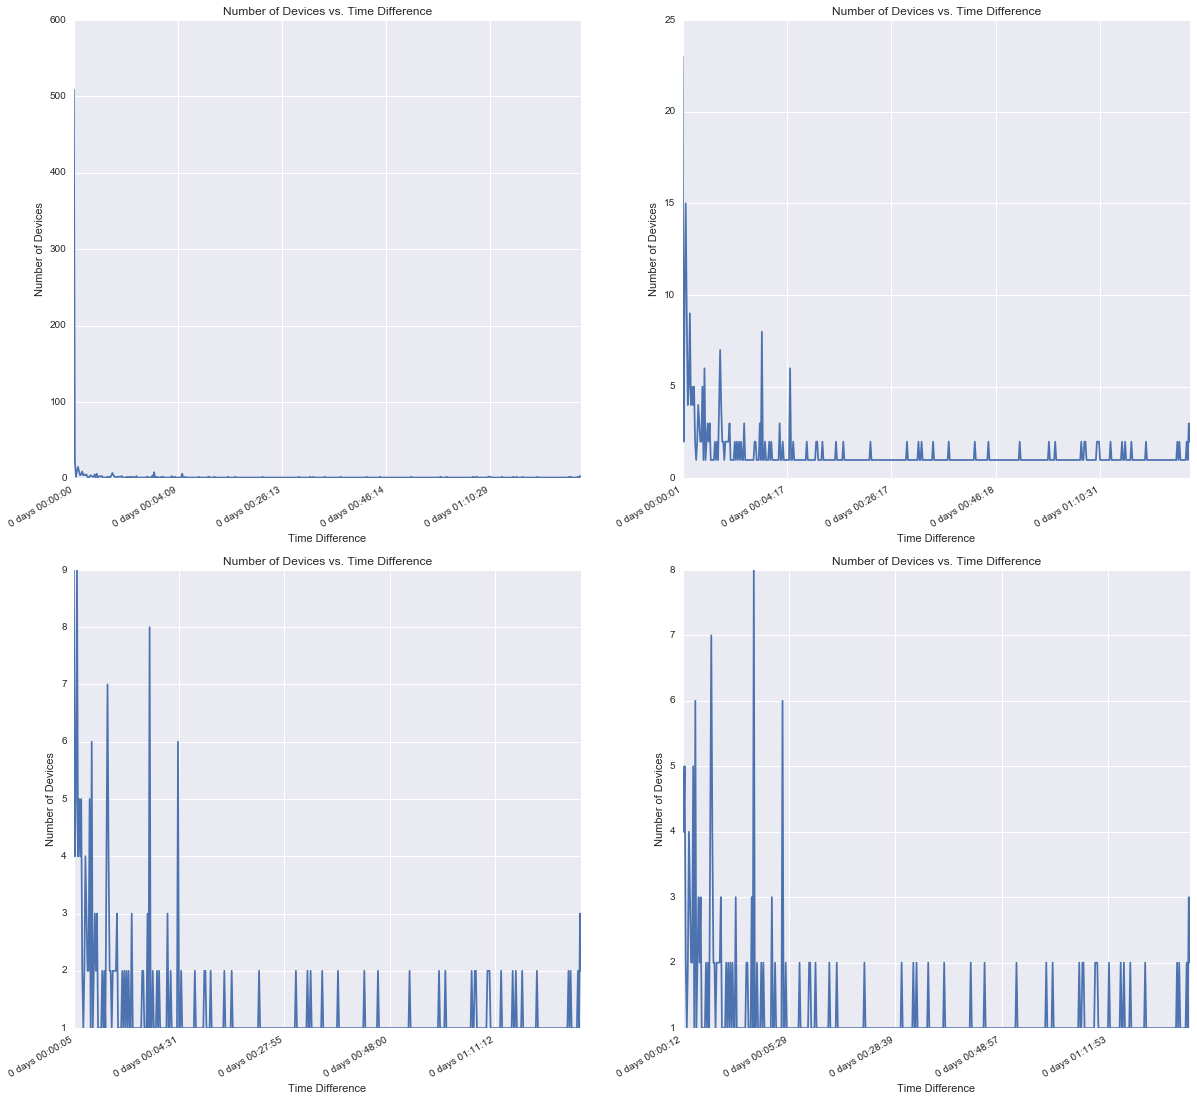

In [34]:
df_plot = df_test.groupby('time_diff').size()
plt.figure(figsize = [20,20])
matplotlib.rcParams.update({'font.size': 22})

plt.subplot(221)
df_plot.plot()
plt.title('Number of Devices vs. Time Difference')
plt.xlabel('Time Difference')
plt.ylabel('Number of Devices')

plt.subplot(222)
df_plot[1:].plot()
plt.title('Number of Devices vs. Time Difference')
plt.xlabel('Time Difference')
plt.ylabel('Number of Devices')

plt.subplot(223)
df_plot[5:].plot()
plt.title('Number of Devices vs. Time Difference')
plt.xlabel('Time Difference')
plt.ylabel('Number of Devices')

plt.subplot(224)
df_plot[10:].plot()
plt.title('Number of Devices vs. Time Difference')
plt.xlabel('Time Difference')
plt.ylabel('Number of Devices')

plt.savefig('./visuals/num_dev_timediff_2.png')

In [36]:
# Categorize time difference into 10 bins

labeled = pd.cut(df_test.time_diff.apply(lambda x: x.total_seconds()), 10, labels = range(10))
df_test['time_label'] = labeled

/Users/macbook/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


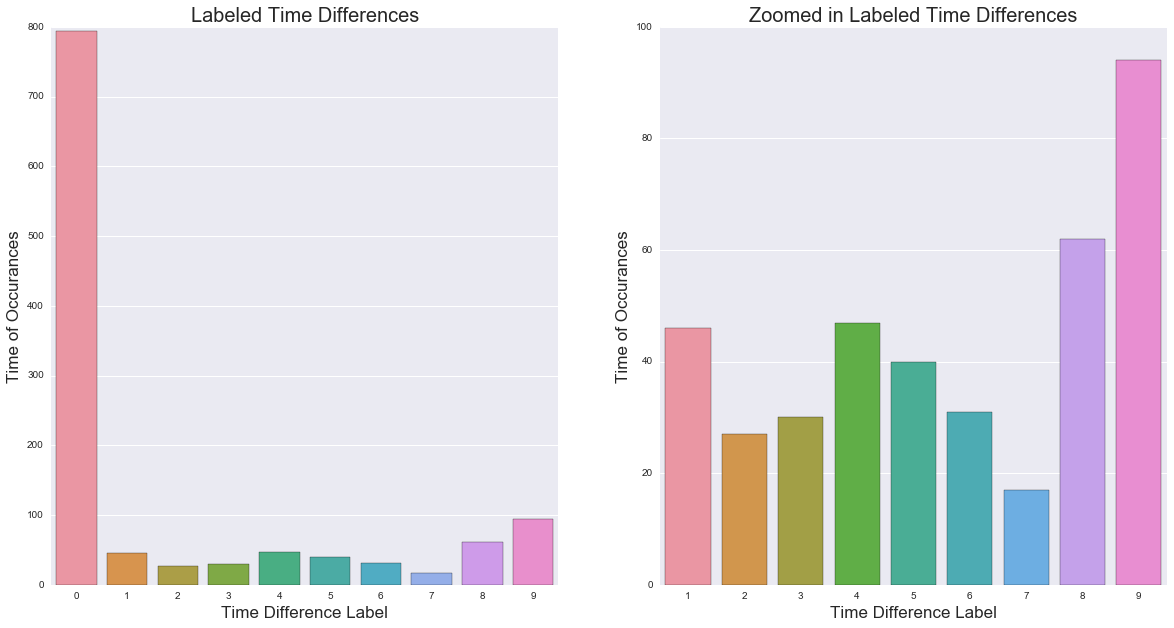

In [37]:
plt.figure(figsize = (20,10))

plt.subplot(121)
sns.barplot(range(10),df_test.groupby('time_label').size())
plt.title('Labeled Time Differences', fontsize = 20)
plt.xlabel('Time Difference Label', fontsize = 17)
plt.ylabel('Time of Occurances', fontsize = 17)

plt.subplot(122)
sns.barplot(range(1,10),df_test.groupby('time_label').size()[1:])
plt.title('Zoomed in Labeled Time Differences', fontsize = 20)
plt.xlabel('Time Difference Label', fontsize = 17)
plt.ylabel('Time of Occurances', fontsize = 17)

plt.savefig('./visuals/labeled_time_diff_2.png', fontsize = 20)

'\nplt.subplot(224)\n# filter out time_diff = 0 & time_diff = 1\n# plot out log(counts)\nplt.plot( log(gp[0][2:]))\nplt.xticks([])\n'

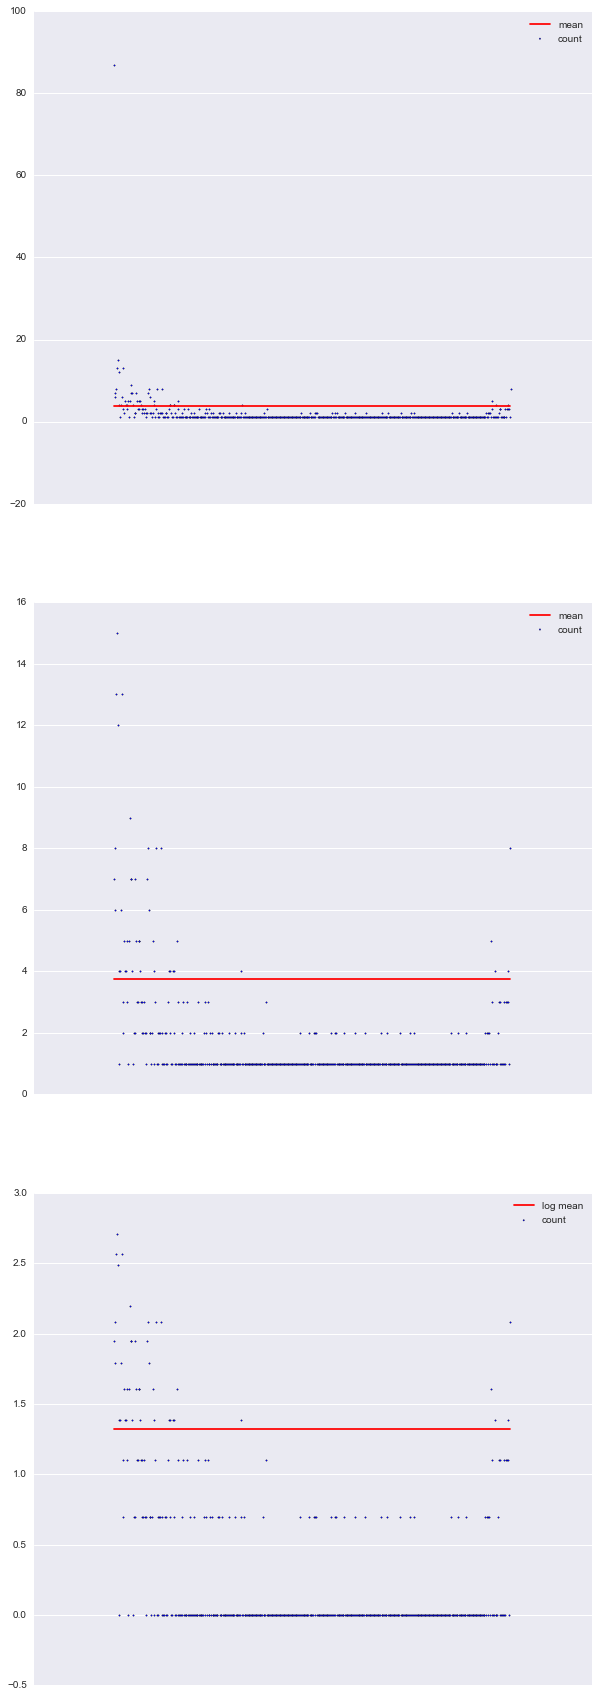

In [171]:
# scatter plot it
import matplotlib.pyplot as plt
plt.figure(figsize=[10,30])


plt.subplot(311)
# filter out time_diff = 0
plt.scatter(range(len(gp)-1), gp[0][1:], s=2, label = 'count')
plt.plot([m] * (len(gp)-2), c = 'r', label = 'mean')
plt.xticks([])
plt.legend()

plt.subplot(312)
# filter out time_diff = 0 & time_diff = 1
plt.scatter(range(len(gp)-2), gp[0][2:], s=2, label = 'count')
plt.plot([m] * (len(gp)-2), c = 'r', label = 'mean')
plt.xticks([])
plt.legend()

plt.subplot(313)
# filter out time_diff = 0 & time_diff = 1
# plot out log(counts)
plt.scatter(range(len(gp)-2), log(gp[0][2:]), s=2, label = 'count')
plt.plot([log(m)] * (len(gp)-2), c = 'r', label = 'log mean')
plt.xticks([])
plt.legend()

'''
plt.subplot(224)
# filter out time_diff = 0 & time_diff = 1
# plot out log(counts)
plt.plot( log(gp[0][2:]))
plt.xticks([])
'''

## filter out multi clients networks 
## make viz nicer 
## Frequency? proxy for distance 
 